# Physics-informed Neural Networks in PyTorch

Combining neural networks with partial differential equations.

### References

+ Early work, basically PINNs:
Lagaris, I. E., Likas, A., & Fotiadis, D. I. (1998). Artificial neural networks for solving ordinary and partial differential equations. IEEE transactions on neural networks

+ Popularized PINN methodology:
Raissi, M., Perdikaris, P., & **Karniadakis, G. E.** (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics

+ **Cool application of PINNs in fluid mechanics:**
Raissi, M., Yazdani, A., & Karniadakis, G. E. (2020). Hidden fluid mechanics: Learning velocity and pressure fields from flow visualizations. Science

+ Automatic differentiation (in ML):
Baydin, A. G., Pearlmutter, B. A., Radul, A. A., & Siskind, J. M. (2017). Automatic differentiation in machine learning: a survey. The Journal of Machine Learning Research

## PINN methodology

Solve PDE $\mathcal{L}u=0$ for solution $u$ being a neural network, $u(x) = u^{NN}(x, \theta)$ by formulating the PDE problem as optimization problem in $\theta$:

$\min_{\theta} L(\theta) = \min_{\theta} \sum_{x_i \in \partial\Omega} (u^{NN}(x_i)-g(x_i))^2 + \sum_{x_i \in \Omega} (\mathcal{L}u^{NN}(x_i))^2$

where $u = g $ for $x \in \partial\Omega$ is a Dirichlet boundary condition.

## Hence we need:

1. Neural network $u^{NN}(\theta) \quad \qquad \qquad \rightarrow \qquad$ PyTorch: Tensors, Activation Functions, Parameters,  ... 
2. Derivatives $\frac{du^{NN}}{dx}, ... \qquad \qquad \qquad \rightarrow \qquad$ Automatic differentiation
3. Algorithm to find $\theta = \text{argmin} L(\theta) \qquad \rightarrow \qquad $ Gradient-based optimization: SGD, L-BFGS

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Check if PyTorch finds a GPU (has to be NVIDIA):

Note that for small data sets and small networks, CPU will be faster.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU ", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU  Quadro P520


# 0. Tensors

Basic data structure, almost like numpy.arrays, but with support fo GPU and automatic differentiation

In [3]:
x = torch.linspace(0, 1, 100, device=device)

# Can also create tensors from numpy arrays:
# x = torch.from_numpy(np.linspace(0,1,100))
# x = x.to(device)

Can often do things in numpy style:

In [4]:
x.shape

torch.Size([100])

In [5]:
torch.mean(x)

tensor(0.5000, device='cuda:0')

In [6]:
x = x[x < 0.5]

In [7]:
x.shape

torch.Size([50])

In [8]:
torch.mean(x)

tensor(0.2475, device='cuda:0')

# 1. Neural Networks 

In [9]:
class Net(torch.nn.Module):

    def __init__(self, num_hidden_units, num_hidden_layers, inputs, outputs=1):
        
        super(Net, self).__init__()        
        
        self.num_hidden_units = num_hidden_units
        self.num_hidden_layers = num_hidden_layers
        
        # Dimensions of input/output
        self.inputs =  inputs
        self.outputs = outputs
        
        self.input_layer = torch.nn.Linear(self.inputs, self.num_hidden_units)
        
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(
            self.num_hidden_units, self.num_hidden_units)
            for i in range(self.num_hidden_layers - 1)])

        self.output_layer = torch.nn.Linear(self.num_hidden_units, self.outputs)
        
        # Use hyperbolic tangent as activation:
        self.activation = torch.nn.Tanh()
        
    def forward(self, x):
        """[Compute NN output]

        Args:
            x ([torch.Tensor]): input tensor
        Returns:
            [torch.Tensor]: [The NN output]
        """
        # Transform the shape of the Tensor to match what is expected by torch.nn.Linear
        x = torch.unsqueeze(x, 1) 
    
        out = self.input_layer(x)
        
        # The first hidden layer:
        out = self.activation(out)

        # The other hidden layers:
        for i, linearLayer in enumerate(self.linear_layers):
            out = linearLayer(out)
            out = self.activation(out)

        # No activation in the output layer:
        out = self.output_layer(out)

        out = torch.squeeze(out, 1)

        return out

Create a feedforward NN:

In [10]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=2, inputs=1).to(device)

Let's have a look at the trainable parameters (weights and biases):

In [11]:
# Take a look at the weights in one layer:
u_nn.input_layer.weight

Parameter containing:
tensor([[-0.0572],
        [-0.0690],
        [ 0.6150],
        [-0.0568],
        [ 0.3857],
        [-0.9038],
        [-0.8992],
        [-0.7226],
        [-0.4906],
        [ 0.7657],
        [ 0.6991],
        [-0.1104],
        [ 0.4060],
        [ 0.4258],
        [-0.7295],
        [-0.1254]], device='cuda:0', requires_grad=True)

In [12]:
# Print the number of tunable parameter per Parameter object
params = list(u_nn.parameters())
print(list(map(lambda x: x.numel(), params)))

[16, 16, 256, 16, 16, 1]


Let's have a look at the output of the untrained NN:

In [13]:
u_nn_x = u_nn(x)

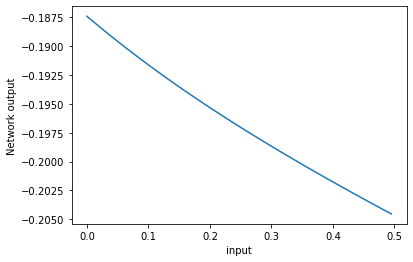

In [14]:
plt.plot(x.tolist(), u_nn_x.tolist())
plt.xlabel("input")
plt.ylabel("Network output");

# 2. Automatic (Algorithmic) differentiation

Example: Derivative of

$ f(x) = \exp(-3x^2) = v_4(v_3(v_2(v_1(x))))$

| | Forward pass: Given $x$, compute       |      
| ----| :----------------------------------------- | 
| $\downarrow$ | $v_1 = x^2$   | 
| $\downarrow$| $v_2 = 3 v_1$ | 
| $\downarrow$| $v_3 = - v_2$ 
| $\downarrow$| $v_4 = \exp v_3$ | 
|  $\downarrow$| $f = v_4 $ |$ \overline{v_4} = \frac{df }{d v_4} = 1$|


We can use the chain rule:

$\frac{df}{dx} =\frac{d f}{d v_4} \frac{d v_4}{d v_3}\frac{d v_3}{d v_2}\frac{d v_2}{d v_1}\frac{d v_1}{dx}$

and the fact that all the derivatives $\frac{d v_{i+1}}{d v_i}$ of the **elementary operations $v_{i+1}(v_i)$** can be considered known!


#### We want to have $\frac{df}{dx}$;

Let us define $ \overline{v_i} = \frac{df}{dv_i}$ and start from  $ \overline{v_4}$ to compute the other $ \overline{v_i}$, utilizing 
+ the stored values $v_i$
+ Known (part of the code base) derivatives $\frac{d v_{i+1}}{d v_i}$ of the elementary operations $v_{i+1}(v_i)$

<div class="foo">
    
|  <div style="width:200px">Forward pass</div>        |           <div style="width:350px">Backward pass</div>               | |
| :----------------------------------------- | :----------------------------------------------------------| -----|
| $v_1 = x^2$   | $ \overline{x} = \frac{d f}{d x} = \overline{v_1}  \frac{d v_1}{d x}= -3 \exp (-3 x^2) \cdot 2 x $ |$\uparrow $ |
| $v_2 = 3 v_1$ | $ \overline{v_1} = \overline{v_2}  \frac{d v_2}{d v_1}= -\exp (v_3) \cdot 3$ |  $\uparrow $ |
| $v_3 = - v_2$ |$ \overline{v_2} = \overline{v_3}  \frac{d v_3}{d v_2}= \exp (v_3) \cdot (-1)$ |$\uparrow $ |
| $v_4 = \exp v_3$ | $ \overline{v_3}= \frac{d f}{d v_3} = \frac{d f}{d v_4} \frac{d v_4}{d v_3} =  \overline{v_4}  \frac{d v_4}{d v_3}= 1 \cdot \exp \color{red} v_{ \color{red} 3}  $ |$\uparrow $ |
| $f = v_4 $ |$ \overline{f} = \overline{v_4} = \frac{df }{d v_4} = 1$| $\uparrow $ |

</div>

This can also be used to compute derivatives with respect to parameters:


$ v_2 = \theta \cdot v_1 \rightarrow  f_{\theta}(x) = \exp(-\theta x^2)$

$\rightarrow \frac{df_{\theta}}{d \theta} = \frac{d f}{d v_4} \frac{d v_4}{d v_3} \frac{d v_3}{d v_2} \frac{d v_2}{d \theta} = \overline{v_2} \frac{d v_2}{d \theta} = \overline{v_2} v_1 
= - \exp (- \theta x^2 ) \cdot  x^2 $

### Using PyTorch autograd to compute derivatives

In [15]:
x = torch.linspace(0, 1, 100, device=device, requires_grad=True)

Two notes: 

+ `requires_grad=True` tells PyTorch to keep track of intermediate results ("create a computational graph")

+ In-place operations `x *= x` are not supported by autograd

In [16]:
y = x ** 2 # torch.sin(np.pi * x)

In [17]:
dy_dx, = torch.autograd.grad(outputs=y,
                             inputs=x,
                             grad_outputs=torch.ones_like(y),
                             create_graph=True)

ddy_dxx, = torch.autograd.grad(outputs=dy_dx,
                             inputs=x,
                             grad_outputs=torch.ones_like(dy_dx),
                             create_graph=True) 

Remark on the last arguments:

1. `grad_outputs=torch.ones_like(y)` is required for non-scalar outputs, technical reasons related to backward automatic differentiation
2. We need to set `create_graph=True` if we want to compute higher order derivatives such that PyTorch adds its computation of `dy_dx` to the computational graph (The same applies if we want to include derivatives into the loss function, because then we need derivatives with respect to NN weights)

In [18]:
# we sometimes want to convert the torch.Tensor back to python types (or numpy arrays):
# Note that a GPU tensor needs to be moved to CPU with the .cpu() call

dy_dx_list = dy_dx.tolist()
dy_dx_np = dy_dx.cpu().detach().numpy()

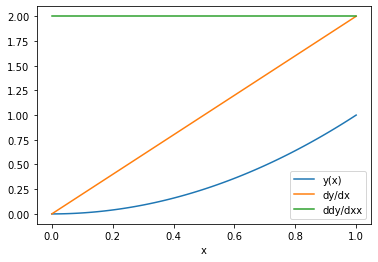

In [19]:
plt.plot(x.tolist(), y.tolist(), label="y(x)") 
plt.plot(x.tolist(), dy_dx.tolist(), label="dy/dx") 
plt.plot(x.tolist(), ddy_dxx.tolist(), label="ddy/dxx") 
plt.xlabel("x")
plt.legend();

# 3. Training

Gradient-based optimization in a nutshell:

while criterion is True:
   1. Compute loss $L(\theta, \text{inputs})$
   2. Update the parameters as $\theta \hookleftarrow \theta - \eta \nabla_{\theta} L (\theta)$

Let's "train" a NN to to fit the sine function.

In [20]:
inputs = torch.linspace(0, 1, 100, device=device)

targets = torch.sin(np.pi * inputs)

In [21]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)
params = list(u_nn.parameters())

In [22]:
optimizer = torch.optim.Adam(params=params)

In [23]:
loss_function=torch.nn.MSELoss(reduction="mean")

In [24]:
losses = []

In [25]:
max_iters = 1000

In [26]:
for i in range(max_iters):
    #  Free all intermediate values:
    optimizer.zero_grad()
    
    # Forward pass:
    predictions = u_nn(inputs)
    
    # Compute the MSE loss:
    loss = loss_function(predictions, targets)
    
    # Backward pass, compute gradient w.r.t. weights and biases
    loss.backward()
    
    # Log the loss to make a figure
    losses.append(loss.item())
    
    # Update the weights and biases
    optimizer.step()

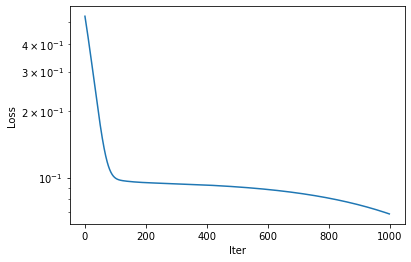

In [27]:
plt.semilogy(losses);
plt.xlabel("Iter")
plt.ylabel("Loss");

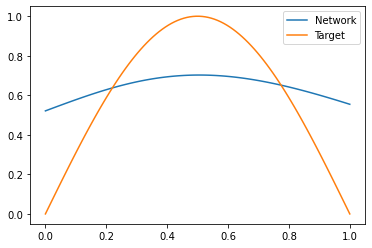

In [28]:
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), label="Network")
plt.plot(inputs.tolist(), targets.tolist(), label="Target")
plt.legend();

## Use a second-order method like L-BFGS:

In [29]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=1, inputs=1).to(device)
params = list(u_nn.parameters())

In [30]:
lbfgs_optim = torch.optim.LBFGS(params,
                                max_iter=max_iters,
                                line_search_fn="strong_wolfe")

losses = []

L-BFGS needs to be used slightly different than first order methods in PyTorch:

The iteration happens inside `lbfgs_optim.step()`, so it is sufficient to call `lbfgs_optim.step()` only once, and specify the number of iterations with the argument `max_iter`. 

In [31]:
# L-BFGS requires one to define a method (called "closure" in the docs) 
# that evaluates the model and returns the loss:

def closure(loss_function=torch.nn.MSELoss(reduction="mean")):
    
    lbfgs_optim.zero_grad()
    
    predictions = u_nn(inputs)
    
    loss = loss_function(predictions, targets)
    
    if loss.requires_grad:
        loss.backward()
        
    losses.append(loss.item())
        
    return loss

Call L-BFGS and plot the loss:

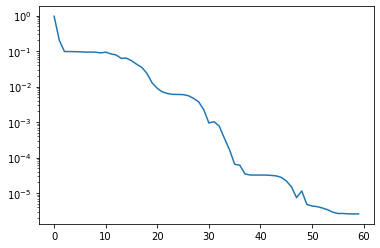

In [32]:
lbfgs_optim.step(closure)
plt.semilogy(losses);

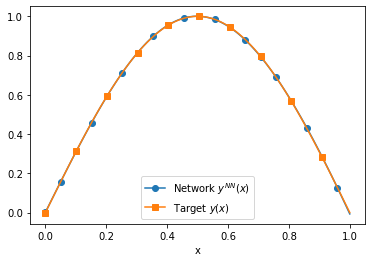

In [33]:
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), marker="o", markevery=5, label="Network $y^{NN}(x)$")
plt.plot(inputs.tolist(), targets.tolist(), marker="s", markevery=10, label="Target $y(x)$")
plt.xlabel("x")
plt.legend();

# 4. Solve PDE with NN in PINN-fashion

Consider $- \Delta u(x) = f(x) = \sin \pi x \text{, }  x \in \Omega = [0,1], u=g=0 \text{ on } \Omega $ 

In [34]:
# Define boundary points and values u(x) on boundary:
boundary_points = torch.tensor([0., 1.], device=device)
boundary_values = torch.zeros_like(boundary_points)

In [35]:
# Define interior points:
residual_points = torch.linspace(0, 1, 100, device=device)

In [36]:
# Define force term:
f = torch.sin(np.pi * residual_points)

# True solution 
true_solution = torch.sin(np.pi * residual_points) / (np.pi**2)

Initialize a Network and construct an optimizer:

In [37]:
u_nn = Net(num_hidden_units=16, num_hidden_layers=2, inputs=1).to(device)

params = list(u_nn.parameters())

loss_function=torch.nn.MSELoss(reduction="mean")

lbfgs_optim = torch.optim.LBFGS(params,
                                max_iter=100,
                                line_search_fn="strong_wolfe")

losses = []

Define the boundary loss and pde residual loss needed for the PINN 

Note that these must be callables that return the loss, cf. the docs for torch.optim

In [38]:
def boundary_loss(nn, boundary_points, boundary_values):
    
    # Evaluate the NN at the boundary:
    predictions = nn(boundary_points)
    
    return loss_function(predictions, boundary_values)

def pde_loss(nn, residual_points, f):
    
    # We want to compute derivatives with respect to the input:
    residual_points.requires_grad = True
    
    # Evaluate NN:
    u = nn(residual_points)
    
    # Compute gradients, note the create_graph=True (it defaults to False)
    du_dx, = torch.autograd.grad(outputs=u,
                             inputs=residual_points,
                             grad_outputs=torch.ones_like(predictions),
                             create_graph=True)

    ddu_dxx, = torch.autograd.grad(outputs=du_dx,
                                 inputs=residual_points,
                                 grad_outputs=torch.ones_like(dy_dx),
                                 create_graph=True) 
    # The residual corresponding to -d^2 u/ dx^2 = f
    residual = ddu_dxx + f
    
    # Evaluate \sum (-d^2 u/ dx^2 - f - 0)^2 (could also do something like torch.mean(residual ** 2))
    return loss_function(residual, torch.zeros_like(residual))

In [39]:
def closure():
    
    lbfgs_optim.zero_grad()
    
    # Compute losses:
    boundary_loss_value = boundary_loss(u_nn, boundary_points, boundary_values)
    
    pde_loss_value = pde_loss(u_nn, residual_points, f)
    
    loss = boundary_loss_value + pde_loss_value
    
    # Compute gradients of the loss w.r.t weights:
    if loss.requires_grad:
        loss.backward()
    
    # Log the loss:
    losses.append(loss.item())
        
    return loss

Optimize and plot the loss:

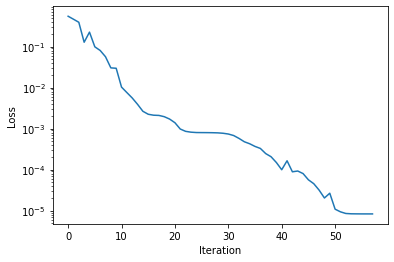

In [40]:
lbfgs_optim.step(closure)

plt.semilogy(losses)
plt.ylabel("Loss")
plt.xlabel("Iteration");

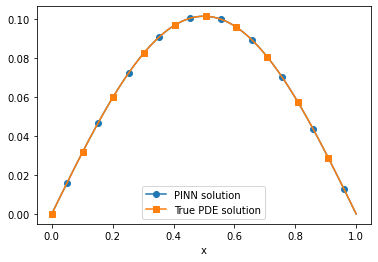

In [41]:
plt.plot(inputs.tolist(), u_nn(inputs).tolist(), marker="o", markevery=5, label="PINN solution")
plt.plot(inputs.tolist(), true_solution.tolist(), marker="s", markevery=10, label="True PDE solution")
plt.xlabel("x")
plt.legend();

# 5. Inverse Problem

Let us consider dynamics of an object in 1-D under gravitation:

$F = m \ddot x = -mg$.

The trajectory is then $y(t) = -\frac{1}{2} g t^2 + v_0 t$ for an object with initial velocity $v_0$ starting from $y=0 $ at $t=0$.

$\rightarrow $ Try to recover $g$ from noisy measurement on the trajectory.

In [42]:
g = 9.81
v_0 = 3.14

Define $t$ and $y(t)$

In [43]:
times = torch.linspace(0, 1, 100, device=device)
positions = -1./2. * g * times ** 2 + v_0 * times

Create some noisy measurements:

In [44]:
amplitude = 0.2
noise = amplitude * torch.from_numpy(np.random.sample(times.shape[0])).to(device) - amplitude / 2.
noisy_positions = (positions + noise).float().to(device)

num_measurements = 50
idx = np.random.choice(np.arange(len(times)), num_measurements, replace=False)
measurement_times = times[idx]
measurements = noisy_positions[idx]

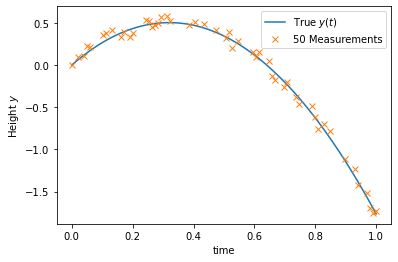

In [45]:
plt.plot(times.tolist(), positions.tolist(), label="True $y(t)$")
# plt.plot(times.tolist(), noisy_positions.tolist(), label="True with Noise")
plt.plot(measurement_times.tolist(), measurements.tolist(), "x", label= str(num_measurements)+ " Measurements")
plt.xlabel("time")
plt.ylabel("Height $y$")
plt.legend();

In [46]:
# Let us try to learn gravitation from the data
# Constrct a Parameter such that PyTorch can optimize it:

# Initialize with bad guess:
g_param = torch.nn.Parameter(torch.tensor(g / 2, device=device))
g_param = g_param.to(device)

In [47]:
y_nn = Net(num_hidden_units=16, num_hidden_layers=2, inputs=1).to(device)

# Don't forget to add g_param to the list of trainable parameters:
params = list(y_nn.parameters()) + [g_param]

loss_function=torch.nn.MSELoss(reduction="mean")

lbfgs_optim = torch.optim.LBFGS(params,
                                max_iter=max_iters,
                                line_search_fn="strong_wolfe")

Again, define callables that return the losses for L-BFGS

In [48]:
def data_loss(nn, data_points, data_values):
    
    predictions = nn(data_points)
    
    return loss_function(predictions, data_values)

def pde_loss(nn, residual_points, g):
    
    residual_points.requires_grad = True
    
    y = nn(residual_points)
    
    dy_dt, = torch.autograd.grad(outputs=y,
                             inputs=residual_points,
                             grad_outputs=torch.ones_like(predictions),
                             create_graph=True)

    ddy_dtt, = torch.autograd.grad(outputs=dy_dt,
                                 inputs=residual_points,
                                 grad_outputs=torch.ones_like(dy_dx),
                                 create_graph=True) 
    # The ODE:
    residual = ddy_dtt + g
    
    return loss_function(residual, torch.zeros_like(residual))

In [49]:
losses = []
g_values = []
def closure():
    
    lbfgs_optim.zero_grad()
    
    data_loss_value = boundary_loss(y_nn, measurement_times, measurements)
    
    pde_loss_value = pde_loss(y_nn, times, g_param)
    
    loss = data_loss_value + pde_loss_value
    
    if loss.requires_grad:
        loss.backward()
        
    # Log both the loss and g during training:
    losses.append(loss.item())
    g_values.append(g_param.item())
    
    return loss

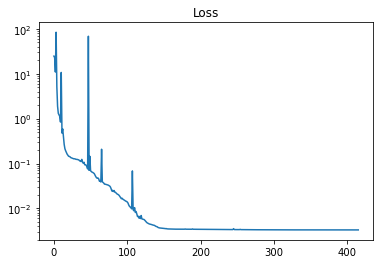

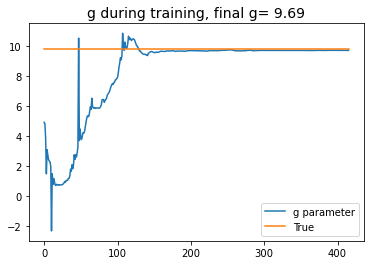

In [50]:
lbfgs_optim.step(closure)

plt.figure()
plt.title("Loss")
plt.semilogy(losses)
plt.show();


plt.figure()
plt.title("g during training, final g= "+format(g_param.item(), ".2f"), fontsize=14)
plt.plot(g_values, label="g parameter")
plt.plot(np.zeros(len(g_values)) + g, label="True")
plt.legend()
plt.show();

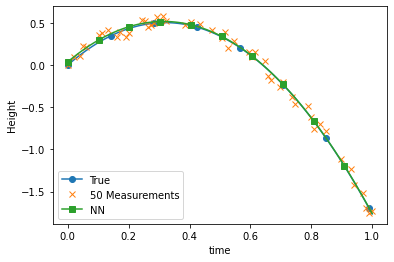

In [51]:
plt.plot(times.tolist(), positions.tolist(), marker="o", markevery=14, label="True");
plt.plot(measurement_times.tolist(), measurements.tolist(), "x", label= str(num_measurements)+ " Measurements")
plt.plot(times.tolist(), y_nn(times).tolist(), "-", marker="s", markevery=10, label="NN");
plt.xlabel("time")
plt.legend()
plt.ylabel("Height");